<a href="https://colab.research.google.com/github/SrTorGonz/Homework-4/blob/main/Brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile

# Subir archivo comprimido (ZIP) que contenga Training/ y Testing/
uploaded = files.upload()

# Descomprimir (si el dataset está en ZIP)
with zipfile.ZipFile(list(uploaded.keys())[0], 'r') as zip_ref:
    zip_ref.extractall('/content')

train_dir = '/content/Training'  # Ajusta según la estructura exacta
test_dir = '/content/Testing'

Saving archive.zip to archive.zip


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
import numpy as np

# 1. Configuración GPU (ejecutar primero)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Error GPU:", e)
        print("Reinicia el runtime (Runtime -> Restart runtime)")

# 2. Preprocesamiento mejorado para MRI
def enhanced_mri_preprocessing(image):
    """Preprocesamiento especializado para imágenes MRI cerebrales"""
    # Convertir a float32 y normalizar a [0,1]
    image = tf.cast(image, tf.float32)
    image = image / tf.reduce_max(image)

    # Convertir a RGB si es escala de grises
    if image.shape[-1] == 1:
        image = tf.repeat(image, 3, axis=-1)

    # Ecualización del histograma en cada canal (mejora contraste)
    def clahe_channel(channel):
        channel = channel.numpy() * 255
        channel = channel.astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(channel) / 255.0

    channels = tf.unstack(image, axis=-1)
    channels = [clahe_channel(ch) for ch in channels]
    image = tf.stack(channels, axis=-1)

    # Normalización específica para VGG16
    return preprocess_input(image * 255.0)  # preprocess_input espera [0,255]

# 3. Generadores de datos con aumento aumentado
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=enhanced_mri_preprocessing,
    rotation_range=15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
)

test_datagen = ImageDataGenerator(
    preprocessing_function=enhanced_mri_preprocessing
)

train_generator = train_datagen.flow_from_directory(
    '/content/Training',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    '/content/Testing',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# 4. Modelo VGG16 mejorado
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(*TARGET_SIZE, 3)
)
base_model.trainable = False  # Congelar inicialmente

# Capas personalizadas mejoradas
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(4, activation='softmax')(x)

model = Model(base_model.input, output)

# 5. Compilación inicial
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Callbacks mejorados
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# 7. Entrenamiento inicial
print("Entrenamiento inicial con capas base congeladas")
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)

# 8. Fine-tuning (descongelar capas superiores)
#print("\nFine-tuning de capas superiores")
#base_model.trainable = True
#for layer in base_model.layers[:15]:
#    layer.trainable = False  # Congelar primeras 15 capas

model.compile(
    optimizer=Adam(learning_rate=1e-5),  # LR más bajo para fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_generator,
    epochs=20,
    initial_epoch=history.epoch[-1],
    validation_data=test_generator,
    callbacks=callbacks
)

# 9. Evaluación final
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nPrecisión Final con VGG16 mejorado: {test_acc:.2%}")


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Entrenamiento inicial con capas base congeladas
Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.3544 - loss: 5.1014

179/179 ━━━━━━━━━━━━━━━━━━━━ 163s 890ms/step - accuracy: 0.3548 - loss: 5.0928 - val_accuracy: 0.7277 - val_loss: 0.7674 - learning_rate: 1.0000e-04
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.5727 - loss: 1.5653

179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 878ms/step - accuracy: 0.5728 - loss: 1.5643 - val_accuracy: 0.7681 - val_loss: 0.6236 - learning_rate: 1.0000e-04
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.6594 - loss: 1.0413

179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 880ms/step - accuracy: 0.6595 - loss: 1.0408 - val_accuracy: 0.7849 - val_loss: 0.5683 - learning_rate: 1.0000e-04
Epoch 4/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.7128 - loss: 0.8163

179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 876ms/step - accuracy: 0.7129 - loss: 0.8162 - val_accuracy: 0.8055 - val_loss: 0.5090 - learning_rate: 1.0000e-04
Epoch 5/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 871ms/step - accuracy: 0.7425 - loss: 0.7153 - val_accuracy: 0.7956 - val_loss: 0.5233 - learning_rate: 1.0000e-04
Epoch 6/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.7656 - loss: 0.6332

179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 871ms/step - accuracy: 0.7656 - loss: 0.6332 - val_accuracy: 0.8024 - val_loss: 0.5039 - learning_rate: 1.0000e-04
Epoch 7/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.7836 - loss: 0.5902

179/179 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7836 - loss: 0.5902 - val_accuracy: 0.8070 - val_loss: 0.4852 - learning_rate: 1.0000e-04
Epoch 8/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.8021 - loss: 0.5280

179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 873ms/step - accuracy: 0.8021 - loss: 0.5280 - val_accuracy: 0.8207 - val_loss: 0.4447 - learning_rate: 1.0000e-04
Epoch 9/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8105 - loss: 0.4938

179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 876ms/step - accuracy: 0.8105 - loss: 0.4939 - val_accuracy: 0.8261 - val_loss: 0.4379 - learning_rate: 1.0000e-04
Epoch 10/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.8203 - loss: 0.4842

179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 869ms/step - accuracy: 0.8203 - loss: 0.4841 - val_accuracy: 0.8322 - val_loss: 0.4144 - learning_rate: 1.0000e-04
Epoch 11/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8308 - loss: 0.4487

179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 867ms/step - accuracy: 0.8308 - loss: 0.4487 - val_accuracy: 0.8322 - val_loss: 0.4125 - learning_rate: 1.0000e-04
Epoch 12/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.8346 - loss: 0.4443

179/179 ━━━━━━━━━━━━━━━━━━━━ 158s 884ms/step - accuracy: 0.8346 - loss: 0.4442 - val_accuracy: 0.8413 - val_loss: 0.4032 - learning_rate: 1.0000e-04
Epoch 13/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 764ms/step - accuracy: 0.8418 - loss: 0.4152

179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 867ms/step - accuracy: 0.8418 - loss: 0.4152 - val_accuracy: 0.8398 - val_loss: 0.3929 - learning_rate: 1.0000e-04
Epoch 14/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.8572 - loss: 0.3924

179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 867ms/step - accuracy: 0.8572 - loss: 0.3925 - val_accuracy: 0.8413 - val_loss: 0.3858 - learning_rate: 1.0000e-04
Epoch 15/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.8543 - loss: 0.3673

179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 868ms/step - accuracy: 0.8544 - loss: 0.3674 - val_accuracy: 0.8497 - val_loss: 0.3669 - learning_rate: 1.0000e-04
Epoch 16/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.8686 - loss: 0.3477

179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 874ms/step - accuracy: 0.8686 - loss: 0.3479 - val_accuracy: 0.8581 - val_loss: 0.3630 - learning_rate: 1.0000e-04
Epoch 17/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.8753 - loss: 0.3324

179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 870ms/step - accuracy: 0.8753 - loss: 0.3324 - val_accuracy: 0.8680 - val_loss: 0.3340 - learning_rate: 1.0000e-04
Epoch 18/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.8715 - loss: 0.3420

179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 865ms/step - accuracy: 0.8715 - loss: 0.3419 - val_accuracy: 0.8719 - val_loss: 0.3263 - learning_rate: 1.0000e-04
Epoch 19/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 154s 863ms/step - accuracy: 0.8818 - loss: 0.3211 - val_accuracy: 0.8757 - val_loss: 0.3270 - learning_rate: 1.0000e-04
Epoch 20/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.8870 - loss: 0.3004

179/179 ━━━━━━━━━━━━━━━━━━━━ 159s 884ms/step - accuracy: 0.8870 - loss: 0.3005 - val_accuracy: 0.8764 - val_loss: 0.3224 - learning_rate: 1.0000e-04
Epoch 21/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 869ms/step - accuracy: 0.8869 - loss: 0.3066 - val_accuracy: 0.8673 - val_loss: 0.3267 - learning_rate: 1.0000e-04
Epoch 22/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.8874 - loss: 0.3023

179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 875ms/step - accuracy: 0.8873 - loss: 0.3023 - val_accuracy: 0.8719 - val_loss: 0.3189 - learning_rate: 1.0000e-04
Epoch 23/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.8941 - loss: 0.2826

179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 874ms/step - accuracy: 0.8941 - loss: 0.2826 - val_accuracy: 0.8848 - val_loss: 0.2876 - learning_rate: 1.0000e-04
Epoch 24/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.8925 - loss: 0.2779

179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 870ms/step - accuracy: 0.8925 - loss: 0.2780 - val_accuracy: 0.8986 - val_loss: 0.2723 - learning_rate: 1.0000e-04
Epoch 25/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 872ms/step - accuracy: 0.8904 - loss: 0.2888 - val_accuracy: 0.8902 - val_loss: 0.2897 - learning_rate: 1.0000e-04
Epoch 26/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 155s 868ms/step - accuracy: 0.9003 - loss: 0.2530 - val_accuracy: 0.8947 - val_loss: 0.2822 - learning_rate: 1.0000e-04
Epoch 27/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9089 - loss: 0.2533

179/179 ━━━━━━━━━━━━━━━━━━━━ 158s 883ms/step - accuracy: 0.9089 - loss: 0.2533 - val_accuracy: 0.8970 - val_loss: 0.2610 - learning_rate: 1.0000e-04
Epoch 28/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 873ms/step - accuracy: 0.9064 - loss: 0.2483 - val_accuracy: 0.9031 - val_loss: 0.2637 - learning_rate: 1.0000e-04
Epoch 29/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 768ms/step - accuracy: 0.9155 - loss: 0.2223

179/179 ━━━━━━━━━━━━━━━━━━━━ 156s 872ms/step - accuracy: 0.9155 - loss: 0.2223 - val_accuracy: 0.9039 - val_loss: 0.2576 - learning_rate: 1.0000e-04
Epoch 30/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.9168 - loss: 0.2201

179/179 ━━━━━━━━━━━━━━━━━━━━ 157s 877ms/step - accuracy: 0.9168 - loss: 0.2202 - val_accuracy: 0.9069 - val_loss: 0.2390 - learning_rate: 1.0000e-04
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 451ms/step - accuracy: 0.9174 - loss: 0.2343

Precisión Final con VGG16 mejorado: 90.69%


Nombres de las clases: ['glioma', 'meningioma', 'notumor', 'pituitary']

Evaluación detallada en el conjunto de test:
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 449ms/step - accuracy: 0.8931 - loss: 0.2522

Exactitud (Accuracy) en test: 0.9069
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 436ms/step - accuracy: 0.9127 - loss: 0.2217
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 453ms/step
Tamaño de y_true: 1311
Tamaño de y_pred_classes: 1311
Matriz de confusión sin normalización


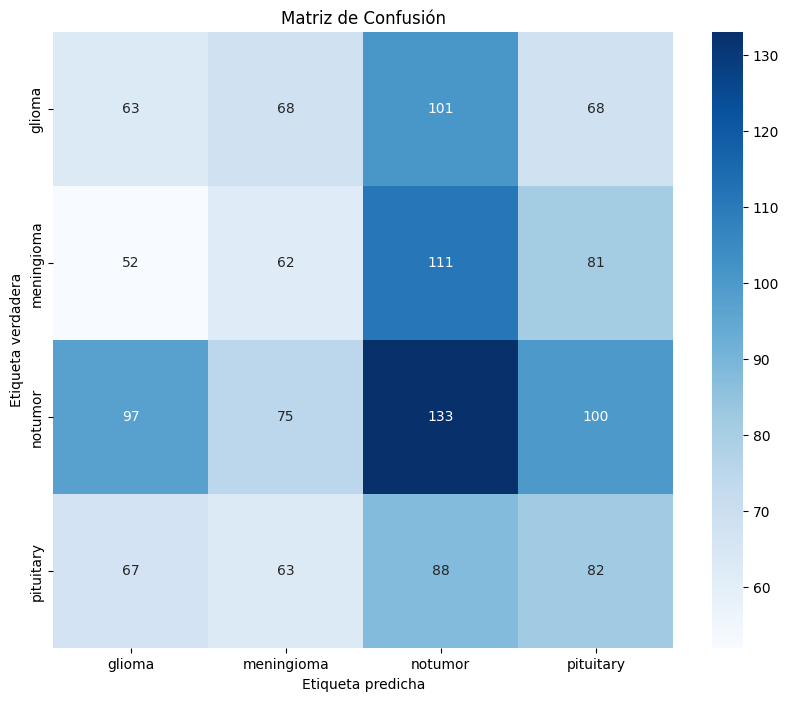


Reporte de Clasificación:
              precision    recall  f1-score   support

      glioma       0.23      0.21      0.22       300
  meningioma       0.23      0.20      0.22       306
     notumor       0.31      0.33      0.32       405
   pituitary       0.25      0.27      0.26       300

    accuracy                           0.26      1311
   macro avg       0.25      0.25      0.25      1311
weighted avg       0.26      0.26      0.26      1311



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Primero obtenemos los nombres de las clases del generador de test
class_names = list(test_generator.class_indices.keys())
print("Nombres de las clases:", class_names)

# 2. Evaluar el modelo en el conjunto de test
print("\nEvaluación detallada en el conjunto de test:")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nExactitud (Accuracy) en test: {test_accuracy:.4f}")

# 3. Predecir las clases para el conjunto de test
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)

test_generator.reset()
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print(f"Tamaño de y_true: {len(y_true)}")
print(f"Tamaño de y_pred_classes: {len(y_pred_classes)}")

# 4. Función para graficar matriz de confusión
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Matriz de Confusión', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalización')

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Etiqueta verdadera')
    plt.xlabel('Etiqueta predicha')
    plt.show()

# 5. Graficar matriz de confusión
plot_confusion_matrix(y_true, y_pred_classes, class_names, normalize=False)

# 6. Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))
